In [2]:
import pandas as pd
from datetime import datetime
import os
import math
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

if os.environ['COMPUTERNAME'] == 'SEA-1800049207Q':
    SP500_BASE_DIRECTORY = "C:\\Users\\brewshan\\Dropbox\\PyCharm Projects\\Market Analysis\\"
elif os.environ['COMPUTERNAME'] == 'SHANE-TRADING-D':
    SP500_BASE_DIRECTORY = "C:\\Users\\Shane\\Dropbox\\PyCharm Projects\\Market Analysis\\"
    
SP500_DATA_DIRECTORY = SP500_BASE_DIRECTORY + "data\\"
SP500_DATA_FILENAME = "SP500.csv"
OUTPUT_DIRECTORY = SP500_BASE_DIRECTORY + "output\\"
OUTPUT_EXCEL_FILENAME = "Bear Market Analysis.xlsx"

plotly.tools.set_credentials_file(username='shane.brewer', api_key='Utd2w2H5xUb4MfnMmlNZ')
plotly.tools.set_config_file(world_readable=True, sharing='public')
sp500_df = pd.read_csv(SP500_DATA_DIRECTORY + SP500_DATA_FILENAME)
sp500_df['Date'] = pd.to_datetime(sp500_df.Date)
#sp500_df = sp500_df.sort_values(by=['Date'], ascending=False)

print(sp500_df.head())

        Date  SP500_Open  SP500_High  SP500_Low  SP500_Close  SP500_Volume  \
0 1950-01-03       16.66       16.66      16.66        16.66             0   
1 1950-01-04       16.85       16.85      16.85        16.85             0   
2 1950-01-05       16.93       16.93      16.93        16.93             0   
3 1950-01-06       16.98       16.98      16.98        16.98             0   
4 1950-01-09       17.08       17.08      17.08        17.08             0   

   SP500_ATRPercentOfClose20  SP500_SQN25  SP500_SQN50  SP500_SQN100  \
0                        0.0          0.0          0.0           0.0   
1                        0.0          0.0          0.0           0.0   
2                        0.0          0.0          0.0           0.0   
3                        0.0          0.0          0.0           0.0   
4                        0.0          0.0          0.0           0.0   

   SP500_SQN200  SP500_MACD  SP500_MACD_Avg  SP500_MACD_Diff  SP500_LinReg10  \
0           0.0   

In [3]:
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

sp500_drawdown_df = sp500_df[['Date', 'SP500_Close']]
sp500_drawdown_df = sp500_drawdown_df.assign(Close_Price_Diff=sp500_drawdown_df['SP500_Close'] -
                                                              sp500_drawdown_df['SP500_Close'].shift(1))
sp500_drawdown_df = sp500_drawdown_df.assign(Close_Price_Diff_Percentage=sp500_drawdown_df['SP500_Close'].pct_change() * 100)

sp500_drawdown_df = sp500_drawdown_df.assign(Cumulative_Price_Diff=sp500_drawdown_df['Close_Price_Diff'].cumsum())

sp500_drawdown_df = sp500_drawdown_df.assign(Max_Gain=sp500_drawdown_df['Cumulative_Price_Diff'].expanding(2).max())

sp500_drawdown_df = sp500_drawdown_df.assign(Peak_To_Trough=sp500_drawdown_df['Cumulative_Price_Diff'] -
                                                      sp500_drawdown_df['Max_Gain'])
sp500_drawdown_df = sp500_drawdown_df.assign(Peak_To_Trough_Percentage=sp500_drawdown_df['Peak_To_Trough'] /
                                                                 (sp500_drawdown_df['SP500_Close'] -
                                                                 sp500_drawdown_df['Peak_To_Trough']) * 100)
wb = Workbook()
ws = wb.create_sheet("Drawdowns")
ws.title = "Drawdowns"
for row in dataframe_to_rows(sp500_drawdown_df, index=True, header=True):
    ws.append(row)
wb.save(OUTPUT_DIRECTORY + OUTPUT_EXCEL_FILENAME)

drawdown_percentage_threshold = 20
max_drawdown_percentage = 0
drawdown_df = pd.DataFrame()

for row in sp500_drawdown_df.itertuples():
    if math.isnan(getattr(row, 'Peak_To_Trough')):
        continue
    if math.isclose(getattr(row, 'Peak_To_Trough'), 0, rel_tol=1e-5) and max_drawdown_percentage < \
            (drawdown_percentage_threshold * -1):
        # Now making new highs, and the last drawdown reached the minimum threshold
        start_date = sp500_drawdown_df.at[last_peak_index, 'Date']
        end_date = sp500_drawdown_df.at[max_drawdown_index, 'Date']
        num_days = (sp500_drawdown_df.at[max_drawdown_index, 'Date'] -
                    sp500_drawdown_df.at[last_peak_index, 'Date']).days

        df = pd.DataFrame({'Start_Date': start_date,
                           'Start_Date_Index': last_peak_index,
                           'End_Date': end_date,
                           'End_Date_Index': max_drawdown_index,
                           'Total_Drawdown_Percentage': max_drawdown_percentage,
                           'Num_Days': num_days}, index=[0])
        
        drawdown_df = drawdown_df.append(df, ignore_index=True)
        last_peak_index = row.Index
        max_drawdown_percentage = 0
        max_drawdown_index = 0
    elif math.isclose(getattr(row, 'Peak_To_Trough'), 0, rel_tol=1e-5):
        # Now making new highs but didn't reach minimum drawdown percentage threshold. Reset variables.
        last_peak_index = row.Index
        max_drawdown_percentage = 0
        max_drawdown_index = 0
    elif max_drawdown_percentage > getattr(row, 'Peak_To_Trough_Percentage'):
        max_drawdown_percentage = getattr(row, 'Peak_To_Trough_Percentage')
        max_drawdown_index = row.Index
pd.DataFrame(drawdown_df)

,Start_Date,Start_Date_Index,End_Date,End_Date_Index,Total_Drawdown_Percentage,Num_Days
0,1956-08-03,1652,1957-10-22,1958,-21.474617,445
1,1961-12-12,3000,1962-06-26,3135,-27.973568,196
2,1966-02-09,4048,1966-10-07,4215,-22.177334,240
3,1968-11-29,4731,1970-05-26,5100,-36.061641,543
4,1973-01-11,5765,1974-10-03,6201,-48.203593,630
5,1980-11-28,7756,1982-08-12,8186,-27.113578,622
6,1987-08-25,9459,1987-12-04,9530,-33.509517,101
7,2000-03-24,12640,2002-10-09,13273,-49.146950,929
8,2007-10-09,14531,2009-03-09,14886,-56.775389,517


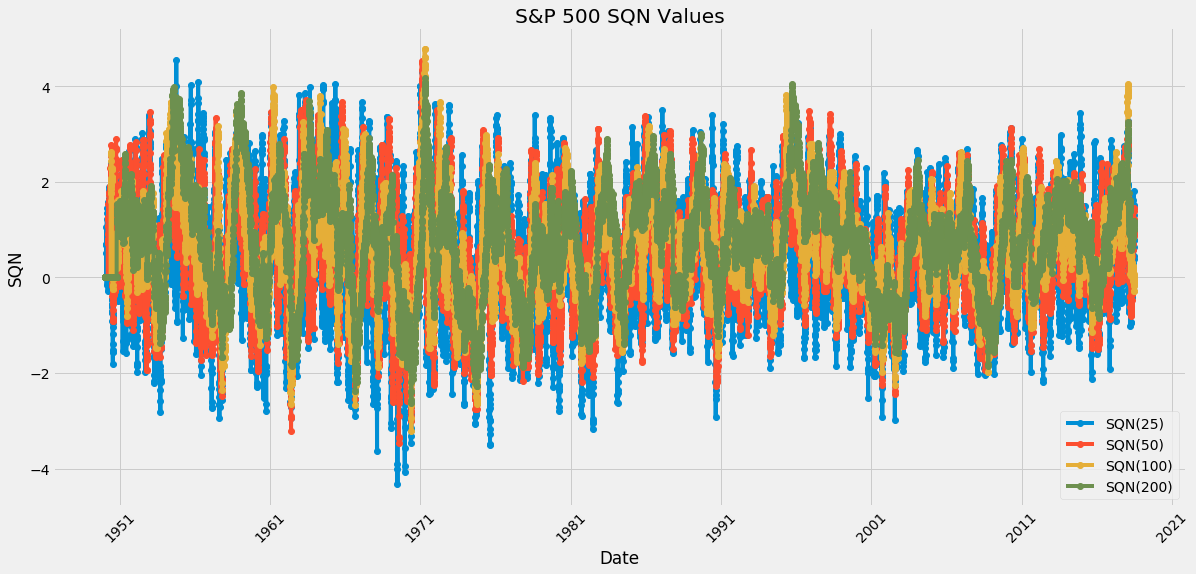

In [4]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style

style.use('fivethirtyeight')
fig = plt.figure()
fig.set_size_inches(18.5, 9.5)
ax1 = plt.subplot2grid((1, 1), (0, 0))
ax1.plot_date(sp500_df['Date'], sp500_df['SP500_SQN25'], linestyle='-', label='SQN(25)')
ax1.plot_date(sp500_df['Date'], sp500_df['SP500_SQN50'], linestyle='-', label='SQN(50)')
ax1.plot_date(sp500_df['Date'], sp500_df['SP500_SQN100'], linestyle='-', label='SQN(100)')
ax1.plot_date(sp500_df['Date'], sp500_df['SP500_SQN200'], linestyle='-', label='SQN(200)')
for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(45)
ax1.grid(True)

plt.title('S&P 500 SQN Values')
plt.xlabel('Date')
plt.ylabel('SQN')
plt.legend()
plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
plt.savefig(OUTPUT_DIRECTORY + 'SP500_SQN.png', dpi=100)
plt.show()

In [14]:
import statistics

sqn_df = pd.DataFrame()
for row in drawdown_df.itertuples():
    # Slice the SP500 df based on start and end dates of the drawdown
    start_index = getattr(row, 'Start_Date_Index')
    end_index = getattr(row, 'End_Date_Index')
    drawdown_slice_df = sp500_df[start_index:end_index + 1]
    
    sqn25_avg = statistics.mean(drawdown_slice_df['SP500_SQN25'])
    sqn25_stdev = statistics.stdev(drawdown_slice_df['SP500_SQN25'])
    sqn25_min = min(drawdown_slice_df['SP500_SQN25'])
    sqn25_max = max(drawdown_slice_df['SP500_SQN25'])
    
    sqn50_avg = statistics.mean(drawdown_slice_df['SP500_SQN50'])
    sqn50_stdev = statistics.stdev(drawdown_slice_df['SP500_SQN50'])
    sqn50_min = min(drawdown_slice_df['SP500_SQN50'])
    sqn50_max = max(drawdown_slice_df['SP500_SQN50'])
    
    sqn100_avg = statistics.mean(drawdown_slice_df['SP500_SQN100'])
    sqn100_stdev = statistics.stdev(drawdown_slice_df['SP500_SQN100'])
    sqn100_min = min(drawdown_slice_df['SP500_SQN100'])
    sqn100_max = max(drawdown_slice_df['SP500_SQN100'])
        
    sqn200_avg = statistics.mean(drawdown_slice_df['SP500_SQN200'])
    sqn200_stdev = statistics.stdev(drawdown_slice_df['SP500_SQN200'])
    sqn200_min = min(drawdown_slice_df['SP500_SQN200'])
    sqn200_max = max(drawdown_slice_df['SP500_SQN200'])
    
    df = pd.DataFrame({
        'START_DATE': getattr(row, 'Start_Date'),
        'END_DATE': getattr(row, 'End_Date'),
        'SQN25_AVG': sqn25_avg, 
        'SQN25_STDEV': sqn25_stdev,
        'SQN25_MIN': sqn25_min,
        'SQN25_MAX': sqn25_max,
        'SQN50_AVG': sqn50_avg,
        'SQN50_STDEV': sqn50_stdev,
        'SQN50_MIN': sqn50_min,
        'SQN50_MAX': sqn50_max,
        'SQN100_AVG': sqn100_avg,
        'SQN100_STDEV': sqn100_stdev,
        'SQN100_MIN': sqn100_min,
        'SQN100_MAX': sqn100_max,
        'SQN200_AVG': sqn200_avg,
        'SQN200_STDEV': sqn200_stdev,
        'SQN200_MIN': sqn200_min,
        'SQN200_MAX': sqn200_max}, index=[0])

    sqn_df = sqn_df.append(df, ignore_index=True)

pd.DataFrame(sqn_df.loc[:, ['START_DATE', 'END_DATE', 'SQN25_AVG', 'SQN25_STDEV', 'SQN25_MIN', 'SQN25_MAX']])

,START_DATE,END_DATE,SQN50_AVG,SQN50_STDEV,SQN50_MIN,SQN50_MAX
0,1956-08-03,1957-10-22,0.037523,1.460058,-2.476764,3.340949
1,1961-12-12,1962-06-26,-0.603034,1.296501,-3.221833,2.745723
2,1966-02-09,1966-10-07,-0.904833,0.661275,-2.548412,1.195650
3,1968-11-29,1970-05-26,-0.536092,1.235149,-3.459557,3.291746
4,1973-01-11,1974-10-03,-0.592193,0.891286,-2.760430,2.397654
5,1980-11-28,1982-08-12,-0.338967,0.823041,-2.187308,1.633844
6,1987-08-25,1987-12-04,-0.165788,0.905469,-1.497074,2.170038
7,2000-03-24,2002-10-09,-0.300204,0.745847,-2.430879,1.894085
8,2007-10-09,2009-03-09,-0.413980,0.641581,-1.929510,1.191665


In [15]:
pd.DataFrame(sqn_df.loc[:, ['START_DATE', 'END_DATE', 'SQN50_AVG', 'SQN50_STDEV', 'SQN50_MIN', 'SQN50_MAX']])

,START_DATE,END_DATE,SQN50_AVG,SQN50_STDEV,SQN50_MIN,SQN50_MAX
0,1956-08-03,1957-10-22,0.037523,1.460058,-2.476764,3.340949
1,1961-12-12,1962-06-26,-0.603034,1.296501,-3.221833,2.745723
2,1966-02-09,1966-10-07,-0.904833,0.661275,-2.548412,1.195650
3,1968-11-29,1970-05-26,-0.536092,1.235149,-3.459557,3.291746
4,1973-01-11,1974-10-03,-0.592193,0.891286,-2.760430,2.397654
5,1980-11-28,1982-08-12,-0.338967,0.823041,-2.187308,1.633844
6,1987-08-25,1987-12-04,-0.165788,0.905469,-1.497074,2.170038
7,2000-03-24,2002-10-09,-0.300204,0.745847,-2.430879,1.894085
8,2007-10-09,2009-03-09,-0.413980,0.641581,-1.929510,1.191665


In [16]:
pd.DataFrame(sqn_df.loc[:, ['START_DATE', 'END_DATE', 'SQN100_AVG', 'SQN100_STDEV', 'SQN100_MIN', 'SQN100_MAX']])

,START_DATE,END_DATE,SQN100_AVG,SQN100_STDEV,SQN100_MIN,SQN100_MAX
0,1956-08-03,1957-10-22,-0.004653,1.005330,-2.352245,3.166333
1,1961-12-12,1962-06-26,-0.260818,1.280677,-2.656774,2.200754
2,1966-02-09,1966-10-07,-0.924179,0.776054,-2.665942,1.361882
3,1968-11-29,1970-05-26,-0.617017,0.853281,-3.214994,1.560682
4,1973-01-11,1974-10-03,-0.643903,0.833684,-2.646580,1.454421
5,1980-11-28,1982-08-12,-0.310950,0.633844,-1.788224,1.844304
6,1987-08-25,1987-12-04,0.269541,0.916277,-0.982405,1.438947
7,2000-03-24,2002-10-09,-0.383539,0.639839,-2.249788,1.343829
8,2007-10-09,2009-03-09,-0.564327,0.439718,-1.986091,0.415516


In [17]:
pd.DataFrame(sqn_df.loc[:, ['START_DATE', 'END_DATE', 'SQN200_AVG', 'SQN200_STDEV', 'SQN200_MIN', 'SQN200_MAX']])

,START_DATE,END_DATE,SQN200_AVG,SQN200_STDEV,SQN200_MIN,SQN200_MAX
0,1956-08-03,1957-10-22,-0.057521,0.593448,-1.675911,1.744213
1,1961-12-12,1962-06-26,0.293451,0.905163,-1.848533,1.594658
2,1966-02-09,1966-10-07,-0.305585,1.068929,-2.381343,1.934586
3,1968-11-29,1970-05-26,-0.382352,1.127722,-2.617828,2.148466
4,1973-01-11,1974-10-03,-0.618545,0.792822,-2.266013,1.580286
5,1980-11-28,1982-08-12,-0.059911,1.037687,-1.540791,2.224735
6,1987-08-25,1987-12-04,0.904416,1.103749,-0.627866,2.402365
7,2000-03-24,2002-10-09,-0.378692,0.582201,-1.573080,1.028299
8,2007-10-09,2009-03-09,-0.556365,0.554395,-1.857383,0.830496
